# Importing Libraries

In [1]:
import os, random, math, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Dataset

In [3]:
DATA_ROOT = "/kaggle/input/70-dog-breedsimage-data-set"

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "valid") 
test_dir  = os.path.join(DATA_ROOT, "test")

print("Train exists:", os.path.isdir(train_dir))
print("Valid exists:", os.path.isdir(val_dir))
print("Test exists :", os.path.isdir(test_dir))

Train exists: True
Valid exists: True
Test exists : True


# Classes Count and Images Splitting

In [4]:
def count_images(root):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    counts = []
    for c in classes:
        cpath = os.path.join(root, c)
        n = len([f for f in os.listdir(cpath) if f.lower().endswith((".jpg",".jpeg",".png"))])
        counts.append((c, n))
    df = pd.DataFrame(counts, columns=["class", "count"]).sort_values("count", ascending=False)
    return df, classes

train_df, classes = count_images(train_dir)
val_df, _ = count_images(val_dir)
test_df, _ = count_images(test_dir)

print("Num classes:", len(classes))
print("Train images:", train_df["count"].sum())
print("Val images  :", val_df["count"].sum())
print("Test images :", test_df["count"].sum())


Num classes: 70
Train images: 7946
Val images  : 700
Test images : 700


# Ploting The Class Balance

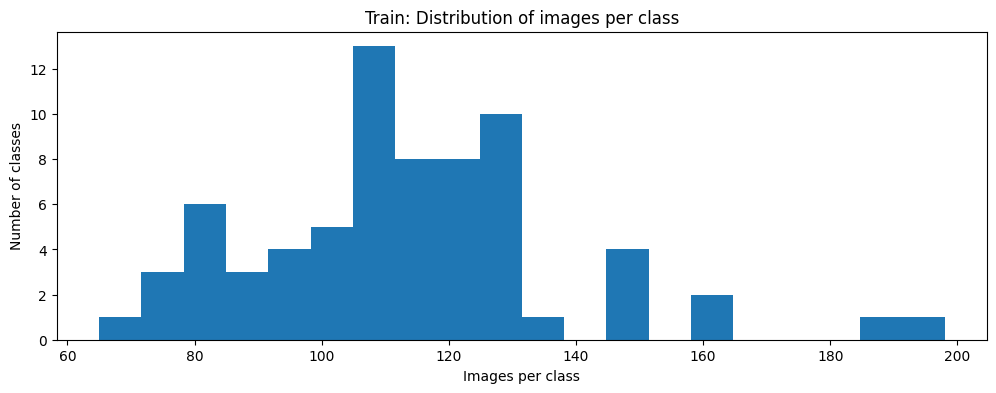

,count
count,70.000000
mean,113.514286
std,24.683353
min,65.000000
25%,99.000000
50%,111.500000
75%,125.000000
max,198.000000


In [5]:
plt.figure(figsize=(12,4))
plt.hist(train_df["count"], bins=20)
plt.title("Train: Distribution of images per class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

train_df.describe()

# Visualize the Random Samples

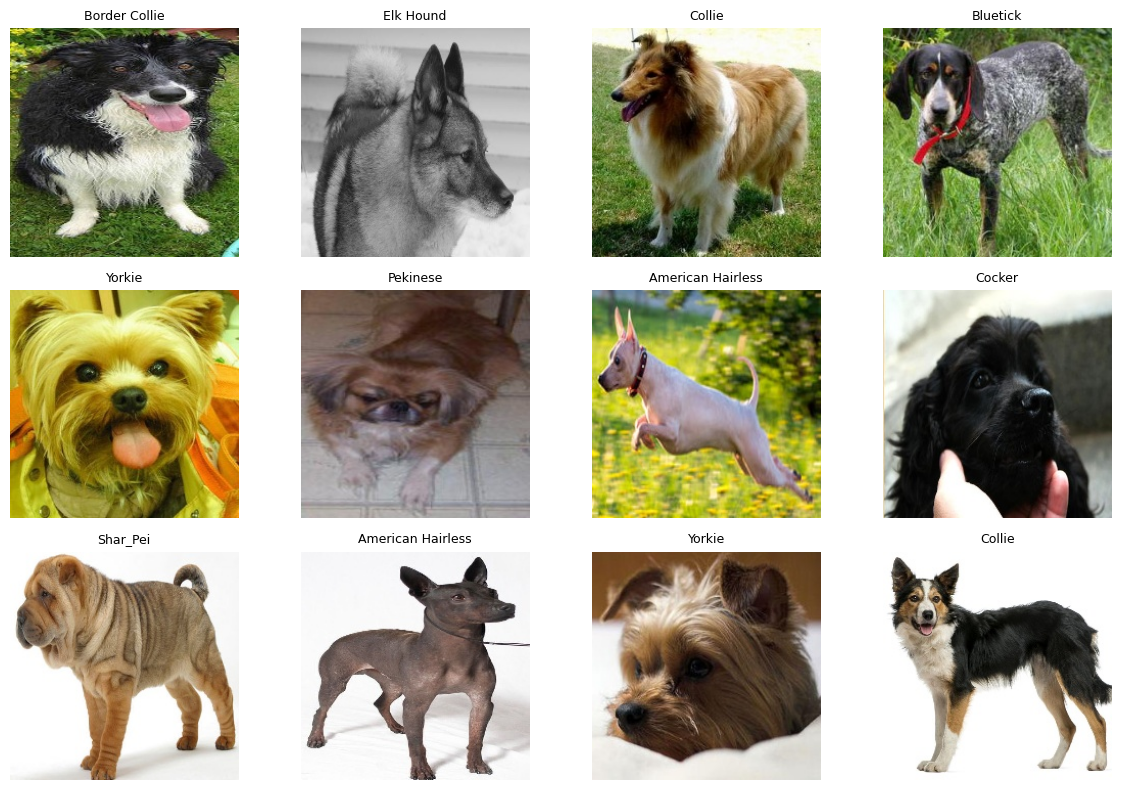

In [6]:
def show_samples(root, classes, n=12):
    plt.figure(figsize=(12,8))
    for i in range(n):
        c = random.choice(classes)
        cdir = os.path.join(root, c)
        img_name = random.choice(os.listdir(cdir))
        img_path = os.path.join(cdir, img_name)
        img = Image.open(img_path).convert("RGB")
        plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(c, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_dir, classes, n=12)

# Checking Image Size Consistency

In [7]:
from collections import Counter

def sample_sizes(root, classes, k=300):
    sizes = []
    for _ in range(k):
        c = random.choice(classes)
        cdir = os.path.join(root, c)
        img_name = random.choice(os.listdir(cdir))
        img_path = os.path.join(cdir, img_name)
        img = Image.open(img_path).convert("RGB")
        sizes.append(img.size)  # (W,H)
    return Counter(sizes).most_common(10)

sample_sizes(train_dir, classes, k=300)

[((224, 224), 300)]

In [8]:
import torchvision.transforms.functional as TF

def compute_mean_std(dataset, num_batches=50, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    mean = 0.
    var  = 0.
    n = 0
    for i, (x, _) in enumerate(loader):
        if i >= num_batches: break
        x = x.to(device)  # [B,3,H,W]
        b = x.size(0)
        x = x.view(b, x.size(1), -1)
        mean += x.mean(dim=2).sum(dim=0)
        var  += x.var(dim=2, unbiased=False).sum(dim=0)
        n += b
    mean /= n
    var  /= n
    std = torch.sqrt(var)
    return mean.detach().cpu().numpy(), std.detach().cpu().numpy()

In [9]:
stats_tf = transforms.Compose([transforms.ToTensor()])
tmp_ds = datasets.ImageFolder(train_dir, transform=stats_tf)
mean, std = compute_mean_std(tmp_ds)
mean, std

(array([0.5255064 , 0.48876953, 0.42011154], dtype=float32),
 array([0.24012756, 0.23869722, 0.24134554], dtype=float32))

In [10]:
dummy_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds_tmp = datasets.ImageFolder(train_dir, transform=dummy_tf)
num_classes = len(train_ds_tmp.classes)
print("Number of classes:", num_classes)

Number of classes: 70


In [11]:
!pip -q install -U timm

import timm
from timm.data import create_transform

# robust import across timm versions
try:
    from timm.data import resolve_data_config
except Exception:
    resolve_data_config = None

MODEL_NAME = "swin_tiny_patch4_window7_224"
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)

if resolve_data_config is not None:
    cfg = resolve_data_config({}, model=model)
    train_tf = create_transform(**cfg, is_training=True)
    eval_tf  = create_transform(**cfg, is_training=False)
else:
    # fallback config (works fine)
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 84.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

# Checking Total Classes

In [28]:
IMG_SIZE = 224
BATCH_SIZE = 64

# Build a temporary train dataset to get class_to_idx
dummy_tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
train_ds_tmp = datasets.ImageFolder(train_dir, transform=dummy_tf)
num_classes = len(train_ds_tmp.classes)
print("Classes:", num_classes)

# Choose a strong transformer (very reliable for 80%+)
MODEL_NAME = "swin_tiny_patch4_window7_224"   # Recommended
# MODEL_NAME = "deit_small_patch16_224"       # Alternative

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)
cfg = resolve_data_config({}, model=model)

train_tf = create_transform(**cfg, is_training=True)
eval_tf  = create_transform(**cfg, is_training=False)

# IMPORTANT: enforce SAME labels across splits (handles folder-name inconsistencies like double spaces)
from torchvision.datasets import ImageFolder
import re

def canon(s: str) -> str:
    # collapse multiple spaces, strip ends, lowercase
    return re.sub(r"\s+", " ", s.strip()).lower()

class ImageFolderWithCanonicalMap(ImageFolder):
    def __init__(self, root, train_class_to_idx, transform=None):
        super().__init__(root=root, transform=transform)

        # canonical mapping from TRAIN
        train_c2i = {canon(k): v for k, v in train_class_to_idx.items()}

        fixed_samples = []
        missing = set()

        for path, local_target in self.samples:
            class_name = self.classes[local_target]   # folder name in this split
            key = canon(class_name)

            if key not in train_c2i:
                missing.add(class_name)
                continue

            fixed_samples.append((path, train_c2i[key]))

        if missing:
            print("WARNING: Some classes in this split were not matched to train (after normalization):")
            for m in sorted(missing)[:30]:
                print(" -", repr(m))
            if len(missing) > 30:
                print(" ... and", len(missing) - 30, "more")

        self.samples = fixed_samples
        self.targets = [t for _, t in self.samples]

train_ds = ImageFolder(train_dir, transform=train_tf)
val_ds   = ImageFolderWithCanonicalMap(val_dir,  train_ds.class_to_idx, transform=eval_tf)
test_ds  = ImageFolderWithCanonicalMap(test_dir, train_ds.class_to_idx, transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Example class:", train_ds.classes[0])
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))

Classes: 70
Example class: Afghan
Val samples: 700
Test samples: 700


In [13]:
print("Test folders:", len([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]))
for d in sorted(os.listdir(test_dir))[:10]:
    if os.path.isdir(os.path.join(test_dir, d)):
        print(d, "->", len(os.listdir(os.path.join(test_dir, d))))

Test folders: 70
Afghan -> 10
African Wild Dog -> 10
Airedale -> 10
American Hairless -> 10
American Spaniel -> 10
Basenji -> 10
Basset -> 10
Beagle -> 10
Bearded Collie -> 10
Bermaise -> 10


In [14]:
from torch.amp import GradScaler, autocast

EPOCHS = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

# Warmup + cosine (very effective)
total_steps = EPOCHS * len(train_loader)
warmup_steps = int(0.1 * total_steps)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scaler = GradScaler(enabled=torch.cuda.is_available())
best_val_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
global_step = 0

In [15]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        b = x.size(0)
        total_loss += loss.item() * b
        total_correct += (logits.argmax(1) == y).sum().item()
        n += b
    return total_loss / n, total_correct / n


# Training Epochs Run

In [16]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss, total_correct, n = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=0.1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()
        global_step += 1

        b = x.size(0)
        total_loss += loss.item() * b
        total_correct += (logits.argmax(1) == y).sum().item()
        n += b

    train_loss = total_loss / n
    train_acc  = total_correct / n
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_transformer.pth")

print("Best Val Acc:", best_val_acc)

Epoch 01 | Train Acc: 0.4186 | Val Acc: 0.9143
Epoch 02 | Train Acc: 0.7486 | Val Acc: 0.9129
Epoch 03 | Train Acc: 0.7438 | Val Acc: 0.9371
Epoch 04 | Train Acc: 0.7824 | Val Acc: 0.9171
Epoch 05 | Train Acc: 0.8111 | Val Acc: 0.9443
Epoch 06 | Train Acc: 0.8275 | Val Acc: 0.9400
Epoch 07 | Train Acc: 0.8340 | Val Acc: 0.9586
Epoch 08 | Train Acc: 0.8511 | Val Acc: 0.9543
Epoch 09 | Train Acc: 0.8596 | Val Acc: 0.9629
Epoch 10 | Train Acc: 0.8721 | Val Acc: 0.9657
Epoch 11 | Train Acc: 0.8937 | Val Acc: 0.9686
Epoch 12 | Train Acc: 0.8949 | Val Acc: 0.9586
Epoch 13 | Train Acc: 0.9026 | Val Acc: 0.9700
Epoch 14 | Train Acc: 0.9212 | Val Acc: 0.9686
Epoch 15 | Train Acc: 0.9257 | Val Acc: 0.9729
Epoch 16 | Train Acc: 0.9362 | Val Acc: 0.9729
Epoch 17 | Train Acc: 0.9406 | Val Acc: 0.9771
Epoch 18 | Train Acc: 0.9475 | Val Acc: 0.9757
Epoch 19 | Train Acc: 0.9498 | Val Acc: 0.9800
Epoch 20 | Train Acc: 0.9469 | Val Acc: 0.9800
Best Val Acc: 0.98


In [26]:
model.load_state_dict(torch.load("best_transformer.pth", map_location=device))

val_loss, val_acc = evaluate(model, val_loader)
print("Best Model - VALID Loss:", val_loss)
print("Best Model - VALID Acc :", val_acc)

Best Model - VALID Loss: 0.17995367028883524
Best Model - VALID Acc : 0.98


In [18]:
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_p, all_y = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(1).cpu().numpy()
        all_p.append(p)
        all_y.append(y.numpy())
    return np.concatenate(all_p), np.concatenate(all_y)

val_preds, val_ys = get_preds(model, val_loader)

print("VALID Accuracy:", (val_preds == val_ys).mean())
print(classification_report(val_ys, val_preds, target_names=val_ds.classes))

VALID Accuracy: 0.98
                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      1.00      1.00        10
American  Spaniel       1.00      1.00      1.00        10
American Hairless       0.88      0.70      0.78        10
          Basenji       1.00      1.00      1.00        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      1.00      1.00        10
   Bearded Collie       1.00      1.00      1.00        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       1.00      1.00      1.00        10
    Border Collie       1.00      0.90      0.95        10
           Borzoi       1.00      

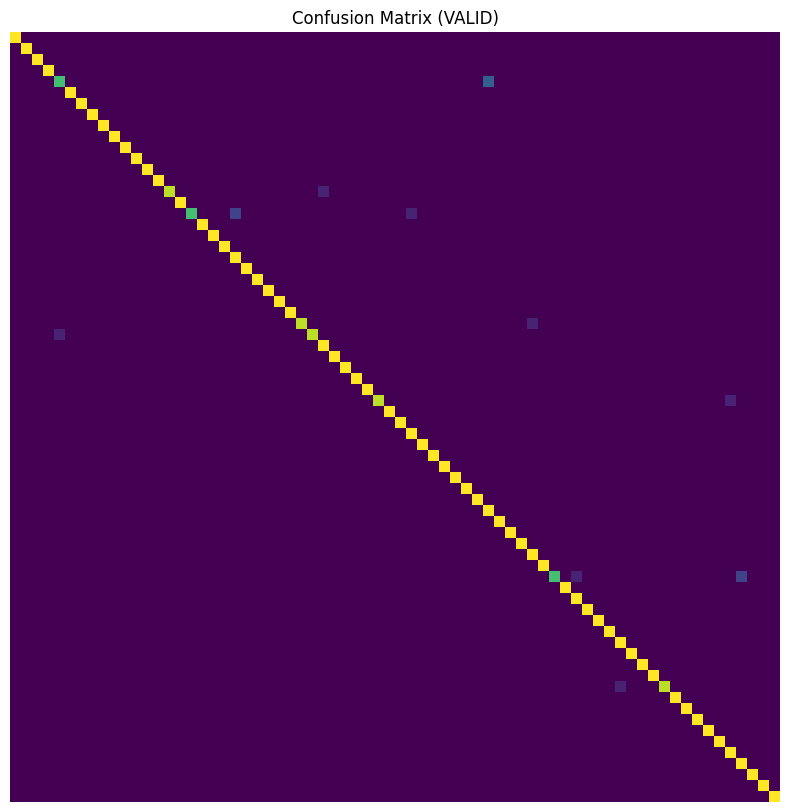

In [19]:
cm = confusion_matrix(val_ys, val_preds)

plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.title("Confusion Matrix (VALID)")
plt.axis("off")
plt.show()

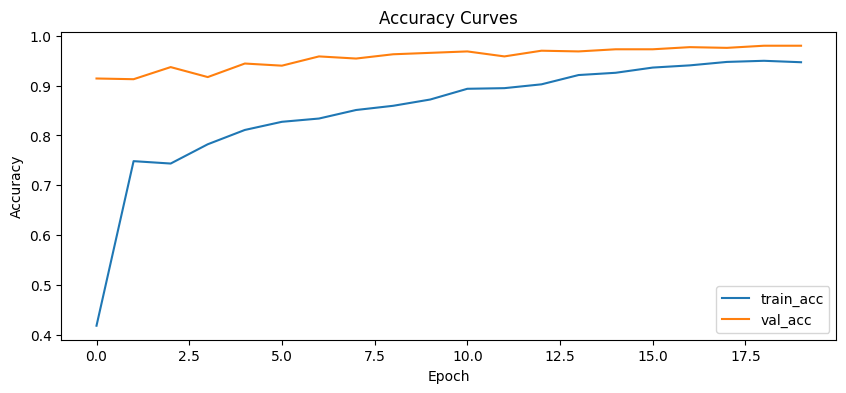

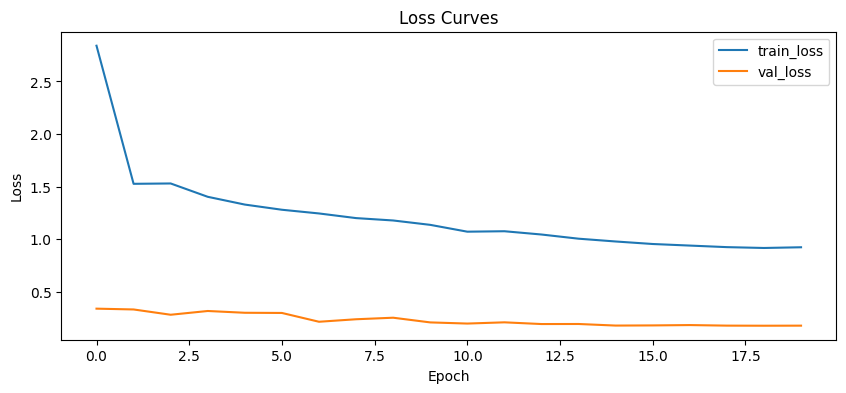

In [20]:
plt.figure(figsize=(10,4))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

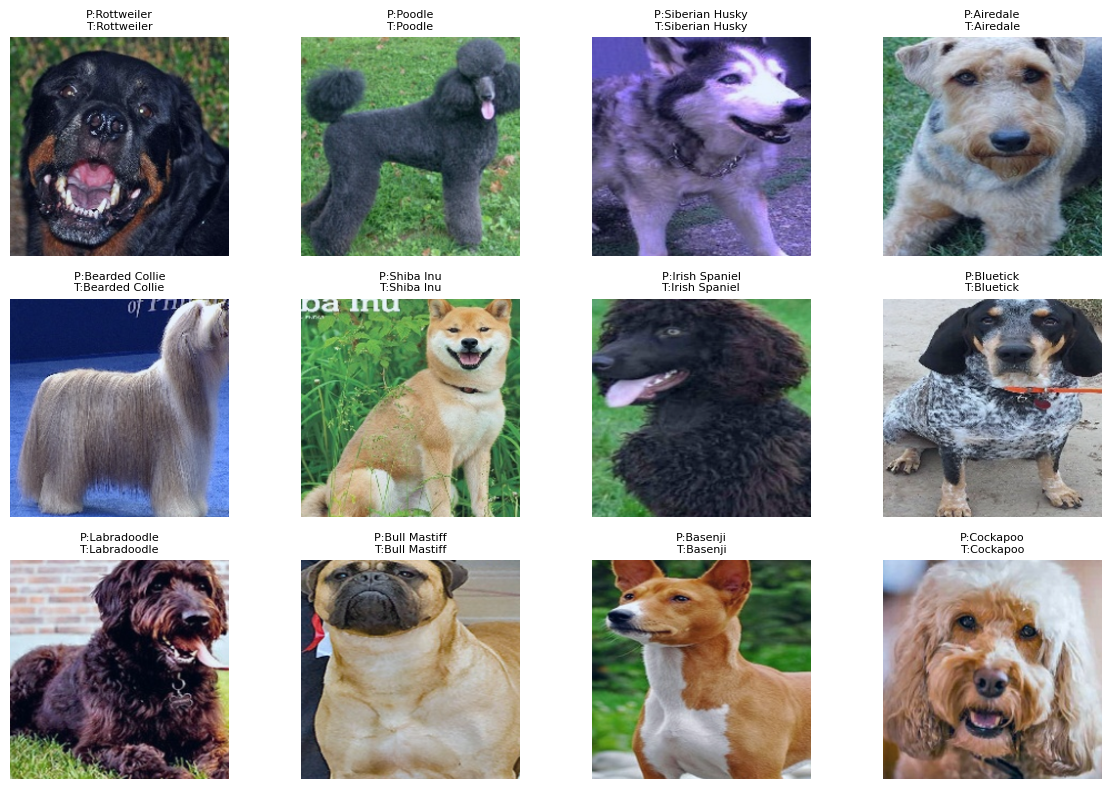

In [21]:
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}

@torch.no_grad()
def show_predictions(model, dataset, n=12):
    model.eval()
    plt.figure(figsize=(12,8))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, y = dataset[idx]
        x = img.unsqueeze(0).to(device)
        logits = model(x)
        pred = logits.argmax(1).item()

        # unnormalize for display (timm transforms are already normalized)
        # just show the tensor as image roughly (optional)
        img_np = img.permute(1,2,0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        plt.subplot(3,4,i+1)
        plt.imshow(img_np)
        title = f"P:{idx_to_class[pred]}\nT:{idx_to_class[y]}"
        plt.title(title, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, val_ds, n=12)

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Load best checkpoint
model.load_state_dict(torch.load("best_transformer.pth", map_location=device))
model.eval()

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

@torch.no_grad()
def predict_pil_image(pil_img, topk=5):
    pil_img = pil_img.convert("RGB")
    x = eval_tf(pil_img).unsqueeze(0).to(device)  # [1,3,224,224]
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]
    top = torch.topk(probs, k=topk)

    labels = [idx_to_class[i] for i in top.indices.cpu().numpy()]
    scores = top.values.cpu().numpy()
    return list(zip(labels, scores))

# --- Use this for a local Kaggle path ---
# Example (change to your uploaded image path):
# img_path = "/kaggle/input/my-uploaded-image/dog.jpg"

def predict_from_path(img_path, topk=5, show=True):
    img = Image.open(img_path).convert("RGB")
    preds = predict_pil_image(img, topk=topk)

    if show:
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Query Image")
        plt.show()
        print("Top predictions:")
        for i, (lab, sc) in enumerate(preds, 1):
            print(f"{i}. {lab:25s}  {sc:.4f}")

    return preds

# Run:
# predict_from_path(img_path)

In [23]:
!pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.


# Gradion Run App on Local

In [24]:
import gradio as gr
import pandas as pd
import torch
from PIL import Image

# Ensure best weights are loaded
model.load_state_dict(torch.load("best_transformer.pth", map_location=device))
model.eval()

idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

@torch.no_grad()
def gradio_predict(img):
    # img comes as a PIL image
    img = img.convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0]

    topk = 5
    top = torch.topk(probs, k=topk)
    labels = [idx_to_class[i] for i in top.indices.cpu().numpy()]
    scores = top.values.cpu().numpy()

    df = pd.DataFrame({"breed": labels, "probability": scores})
    # Also return a dict for Gradio label component
    label_dict = {labels[i]: float(scores[i]) for i in range(topk)}
    return df, label_dict

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil", label="Upload a dog image"),
    outputs=[
        gr.Dataframe(label="Top-5 Predictions", headers=["breed", "probability"], datatype=["str","number"]),
        gr.Label(num_top_classes=5, label="Prediction (Top-5)")
    ],
    title="Dog Breed Classification (Transformer - Swin Tiny)",
    description="Upload an image and the model will predict the dog breed (Top-5).",
    allow_flagging="never"
)

demo.launch(debug=False)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://b7d1eca0a5d2679362.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
